In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
from pathlib import Path

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (LSTM, Dense, Dropout, Conv1D, BatchNormalization)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_absolute_percentage_error,mean_squared_error
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split

In [39]:
def reduce_memory_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print(f"Memory usage of dataframe is: {start_mem:.2f} MB")

    for col in df.columns:
        if df[col].dtype == "float64":
            df[col] = pd.to_numeric(df[col], downcast="float")
        elif df[col].dtype == "int64":
            df[col] = pd.to_numeric(df[col], downcast="integer")
        elif df[col].dtype == "object":
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print(f"Memory usage after optimization is: {end_mem:.2f} MB")

    return df


In [62]:
# Global variables
encoder_map = {}
forecast_horizon = 28
lookback_window = 7
model_path = str("sales_forecast_model.h5")

df_path = str("processed_sales_data.csv")
df = pd.read_csv(df_path)
df = reduce_memory_usage(df)


df.drop(columns=["Unnamed: 0"], inplace=True)

# dropping events for now
events = ['event_1_Cultural', 'event_1_National', 'event_1_None',
       'event_1_Religious', 'event_1_Sporting', 'event_2_Cultural',
       'event_2_None', 'event_2_Religious']
df.drop(columns=events, inplace=True)

# Reducing dataset size
df = df[df["year"] == 2016]

<ipython-input-62-975f88a93de5>:8: DtypeWarning: Columns (24,25,26,27,28,29,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(df_path)


Memory usage of dataframe is: 1252.98 MB
Memory usage after optimization is: 421.01 MB


In [52]:
df.columns

Index(['item_id', 'dept_id', 'cat_id', 'sales', 'wday', 'month', 'year',
       'sell_price', 'lag_7', 'lag_14', 'lag_28', 'rolling_mean_7',
       'rolling_std_7', 'rolling_mean_14', 'rolling_std_14', 'rolling_mean_28',
       'rolling_std_28', 'rolling_mean_56', 'rolling_std_56', 'expanding_mean',
       'price_change_pct', 'rolling_price_std_4w', 'week_of_year',
       'event_1_Cultural', 'event_1_National', 'event_1_None',
       'event_1_Religious', 'event_1_Sporting', 'event_2_Cultural',
       'event_2_None', 'event_2_Religious'],
      dtype='object')

In [63]:

FEATURES = [cols for cols in df.columns if cols not in ['log_sales', 'sales']]
TARGET = "sales"

# Feature Scaling
SCALE_FEATURES = [
    "sell_price",
    "lag_7",
    "lag_14",
    "lag_28",
    "rolling_mean_7",
    "rolling_std_7",
    "rolling_mean_14",
    "rolling_std_14",
    "rolling_mean_28",
    "rolling_std_28",
    "rolling_mean_56",
    "rolling_std_56",
    "expanding_mean",
    "price_change_pct",
    "rolling_price_std_4w",
]
scaler = MinMaxScaler()
df[SCALE_FEATURES] = scaler.fit_transform(df[SCALE_FEATURES])


# Prep as Time series
df.sort_values(["item_id", "year", "month", "wday"], inplace=True)

# Encoding categorical features
cat_features = ["item_id", "dept_id", "cat_id"]
for col in cat_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoder_map[col] = le

# Convert bool to int8
booleans = df.select_dtypes(include=["bool"]).columns
df[booleans] = df[booleans].astype("int8")

df.fillna(method='ffill', inplace=True)


<ipython-input-63-4020c0e521cd>:40: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [64]:
# Train-test split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=False)

# Define input features and target
X_train = train_df[FEATURES].values
y_train = train_df[TARGET].values
X_test = test_df[FEATURES].values
y_test = test_df[TARGET].values


In [65]:
# Generate sequences
train_gen = TimeseriesGenerator(
    X_train, y_train, length=lookback_window, batch_size=128
)

val_gen = TimeseriesGenerator(X_test, y_test, length=lookback_window, batch_size=128)

In [67]:
model = Sequential(
    [
        Conv1D(
            filters=64,
            kernel_size=3,
            activation="relu",
            input_shape=(lookback_window, len(FEATURES)),
        ),
        BatchNormalization(),
        LSTM(64, return_sequences=False),
        Dropout(0.3),
        Dense(32, activation="relu"),
        Dense(1),
    ]
)
# Out: predicted sales value

model.compile(optimizer=Adam(learning_rate=0.001), loss="mse", metrics=["mae"])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [68]:
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint(model_path, save_best_only=True),
    # ModelCheckpoint("best_lstm_model.h5", save_best_only=True),
]

history = model.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=callbacks)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1927/1928 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 23.4806 - mae: 2.3479

1928/1928 ━━━━━━━━━━━━━━━━━━━━ 45s 21ms/step - loss: 23.4803 - mae: 2.3478 - val_loss: 16.7653 - val_mae: 2.1803
Epoch 2/50
1926/1928 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 16.5834 - mae: 2.0569

1928/1928 ━━━━━━━━━━━━━━━━━━━━ 38s 20ms/step - loss: 16.5879 - mae: 2.0569 - val_loss: 15.4540 - val_mae: 2.3963
Epoch 3/50
1928/1928 ━━━━━━━━━━━━━━━━━━━━ 35s 18ms/step - loss: 28.0584 - mae: 2.2574 - val_loss: 15.7410 - val_mae: 2.6781
Epoch 4/50
1928/1928 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 17.3949 - mae: 2.0922

1928/1928 ━━━━━━━━━━━━━━━━━━━━ 37s 19ms/step - loss: 17.3949 - mae: 2.0921 - val_loss: 15.3631 - val_mae: 2.5882
Epoch 5/50
1928/1928 ━━━━━━━━━━━━━━━━━━━━ 36s 19ms/step - loss: 19.8727 - mae: 2.1986 - val_loss: 15.3721 - val_mae: 2.3402
Epoch 6/50
1928/1928 ━━━━━━━━━━━━━━━━━━━━ 33s 17ms/step - loss: 15.2244 - mae: 2.0097 - val_loss: 15.8992 - val_mae: 2.2959
Epoch 7/50
1928/1928 ━━━━━━━━━━━━━━━━━━━━ 38s 20ms/step - loss: 20.3024 - mae: 2.0823 - val_loss: 15.7742 - val_mae: 2.7343
Epoch 8/50
1928/1928 ━━━━━━━━━━━━━━━━━━━━ 35s 18ms/step - loss: 13.7402 - mae: 1.9476 - val_loss: 15.6782 - val_mae: 2.5213
Epoch 9/50
1928/1928 ━━━━━━━━━━━━━━━━━━━━ 34s 18ms/step - loss: 14.2183 - mae: 1.9283 - val_loss: 15.8903 - val_mae: 2.6583
Epoch 10/50
1928/1928 ━━━━━━━━━━━━━━━━━━━━ 42s 18ms/step - loss: 13.2136 - mae: 1.9085 - val_loss: 17.0731 - val_mae: 2.9939
Epoch 11/50
1928/1928 ━━━━━━━━━━━━━━━━━━━━ 35s 18ms/step - loss: 15.6193 - mae: 1.9982 - val_loss: 15.4035 - val_mae: 2.4509
Epoch 12/50
1928/

482/482 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
MAPE: 5379721953017856.0000
RMSE: 3.9196


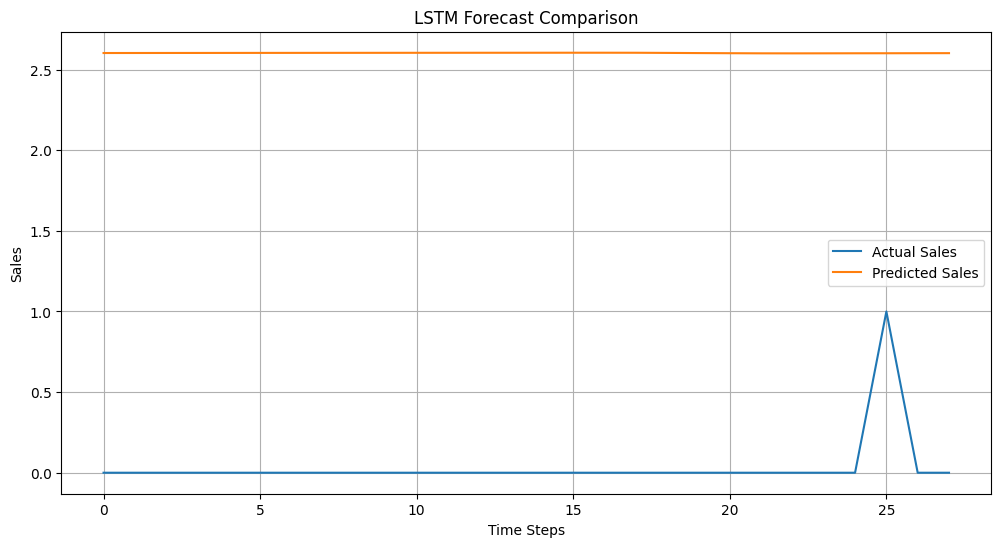

In [69]:
# Metric evaluation
preds = model.predict(val_gen)
sales = y_test[lookback_window:]

mape = mean_absolute_percentage_error(sales, preds)
rmse = np.sqrt(mean_squared_error(sales, preds))

print(f"MAPE: {mape:.4f}")
print(f"RMSE: {rmse:.4f}")

# Plot comparision
plt.figure(figsize=(12, 6))
plt.plot(range(forecast_horizon), sales[:forecast_horizon], label="Actual Sales")
plt.plot(range(forecast_horizon), preds[:forecast_horizon], label="Predicted Sales")
plt.title("LSTM Forecast Comparison")
plt.xlabel("Time Steps")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.show()

In [70]:
model.save(model_path)